<a href="https://colab.research.google.com/github/madhav48/AI-Investment-ChatBot-SOC-2024/blob/main/Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock Price Forecasting using ARIMA, SARIMA and Exponential Smoothing models

#Necessary Imports

In [ ]:
import yfinance as yf

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from datetime import timedelta

import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)



#Get Stock Data using yfinance..

In [ ]:
nifty_ticker = yf.Ticker("^NSEI")    # Ticket for Nifty 50...

# get all stock info for Nifty 50..
nifty_ticker.info

{'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 23537.85,
 'open': 23577.1,
 'dayLow': 23562.05,
 'dayHigh': 23754.15,
 'regularMarketPreviousClose': 23537.85,
 'regularMarketOpen': 23577.1,
 'regularMarketDayLow': 23562.05,
 'regularMarketDayHigh': 23754.15,
 'averageVolume': 341840,
 'averageVolume10days': 312720,
 'averageDailyVolume10Day': 312720,
 'fiftyTwoWeekLow': 18714.25,
 'fiftyTwoWeekHigh': 23754.15,
 'fiftyDayAverage': 22685.387,
 'twoHundredDayAverage': 21308.49,
 'currency': 'INR',
 'exchange': 'NSI',
 'quoteType': 'INDEX',
 'symbol': '^NSEI',
 'underlyingSymbol': '^NSEI',
 'shortName': 'NIFTY 50',
 'longName': 'NIFTY 50',
 'firstTradeDateEpochUtc': 1190000700,
 'timeZoneFullName': 'Asia/Kolkata',
 'timeZoneShortName': 'IST',
 'uuid': '9a3680d6-8f20-3f84-8cd3-66d847143a00',
 'messageBoardId': 'finmb_INDEXNSEI',
 'gmtOffSetMilliseconds': 19800000,
 'trailingPegRatio': None}

In [ ]:
# Download historical stock price data..
data = yf.download("^NSEI",  start = "2023-03-01", end = "2024-03-01")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-01,17360.099609,17467.750000,17345.250000,17450.900391,17450.900391,272900
2023-03-02,17421.500000,17445.800781,17306.000000,17321.900391,17321.900391,310700
2023-03-03,17451.250000,17644.750000,17427.699219,17594.349609,17594.349609,356200
2023-03-06,17680.349609,17799.949219,17671.949219,17711.449219,17711.449219,362800
2023-03-08,17665.750000,17766.500000,17602.250000,17754.400391,17754.400391,267000
...,...,...,...,...,...,...
2024-02-23,22290.000000,22297.500000,22186.099609,22212.699219,22212.699219,226000
2024-02-26,22169.199219,22202.150391,22075.150391,22122.050781,22122.050781,207800
2024-02-27,22090.199219,22218.250000,22085.650391,22198.349609,22198.349609,252200


#Data Extraction according to needs

In [ ]:
# Extract the data into seprate arrays to use as per need of model and easy visaulization..
close_prices = data["Close"]
open_prices = data ["Open"]

df = close_prices

In [ ]:
df.head()

Date
2023-03-01    17450.900391
2023-03-02    17321.900391
2023-03-03    17594.349609
2023-03-06    17711.449219
2023-03-08    17754.400391
Name: Close, dtype: float64

#Data Ploting

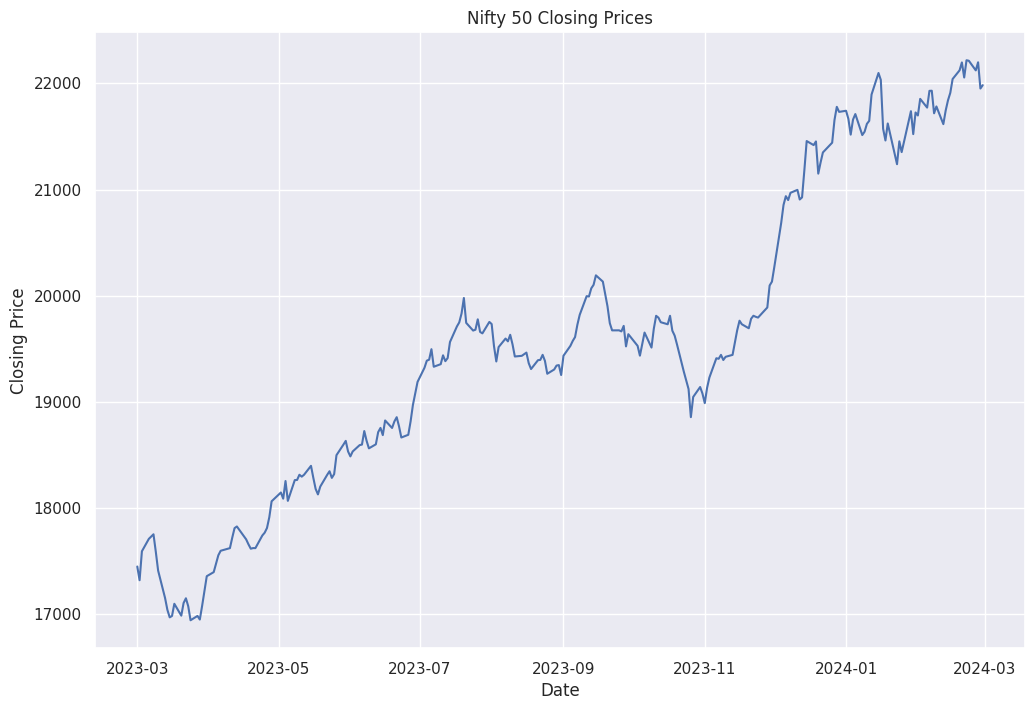

In [ ]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.lineplot(data= df)

# Add title and labels
plt.title('Nifty 50 Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

#Seasonal Decompostion

Seasonal decompostion gives a good idea of the constituents of the time series - trend, seasonality and residual. This helps us to deal with each of them seprately and make our task easy.

<ul>

<li> Additive - Observed = Trend + Season + Residual</li>
<li> Multiplicative - Observed = Trend x Season x Residual </li>

</ul>

Period - The number of observations in one cycle of the seasonal pattern. For Example for a week - 5, For a month - 21

These observations later on helps us to tune the parameters of the models like ARIMA and SARIMA and enable them to perform more better.

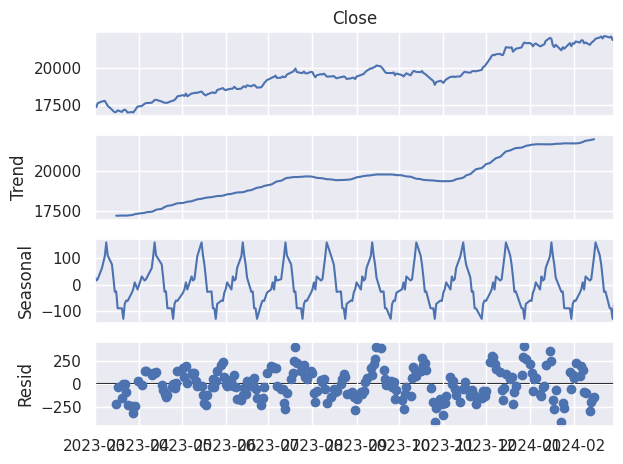

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df, period=21 ,model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

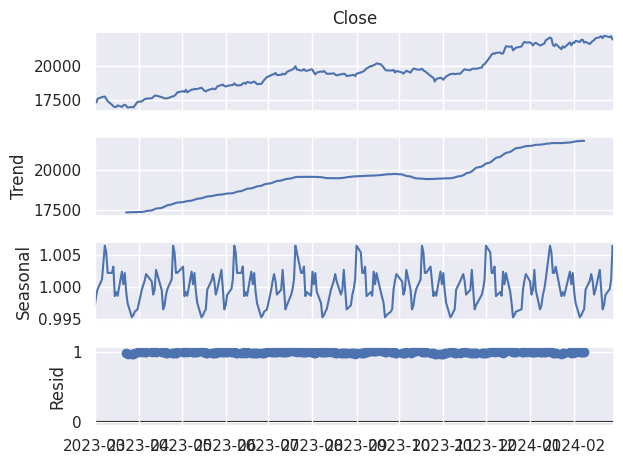

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df, period=30 ,model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

Residual -- 1 means data is very well behaved and can be easily predicted using trend and seasonlity.

#Stationarity Test - ADF Test

For Time Series models, to perform better it is important that data is stationary which means:

<ul>
<li> Data has constant mean </li>
<li> Data has constant standard deviation </li>
<li> Data has no seasonality </li>
</uL>

Although there are various methods like visual checkups for stationarity test, but ADFuller is the most robust one to find out.

In [ ]:
# Check for stationarity..

def test_stationarity(timeseries):
  adf = adfuller(timeseries)

  # Print the results of the test
  print('ADF Statistic: {}'.format(adf[0]))
  print('p-value: {}'.format(adf[1]))

  # If the p-value is less than 0.05, the data is stationary
  if adf[1] < 0.05:
      print('The data is stationary')
  else:
      print('The data is not stationary')
test_stationarity(df)

ADF Statistic: -0.44928002797769934
p-value: 0.9015399604718921
The data is not stationary


#Bring Stationarity

To bring stationary, there are many ways but the most intuitive thing is to take first difference of data.

In [ ]:
first_diff_df = df.diff()
first_diff_df.dropna(inplace=True)
first_diff_df

Date
2023-03-02   -129.000000
2023-03-03    272.449219
2023-03-06    117.099609
2023-03-08     42.951172
2023-03-09   -164.800781
                 ...    
2024-02-23     -4.750000
2024-02-26    -90.648438
2024-02-27     76.298828
2024-02-28   -247.199219
2024-02-29     31.650391
Name: Close, Length: 245, dtype: float64

Check the data again for stationarity..

In [ ]:
test_stationarity(first_diff_df)

ADF Statistic: -14.748710898693767
p-value: 2.5044979968600696e-27
The data is stationary


Hence, data is stationary now. So now Difference Data Plotting -

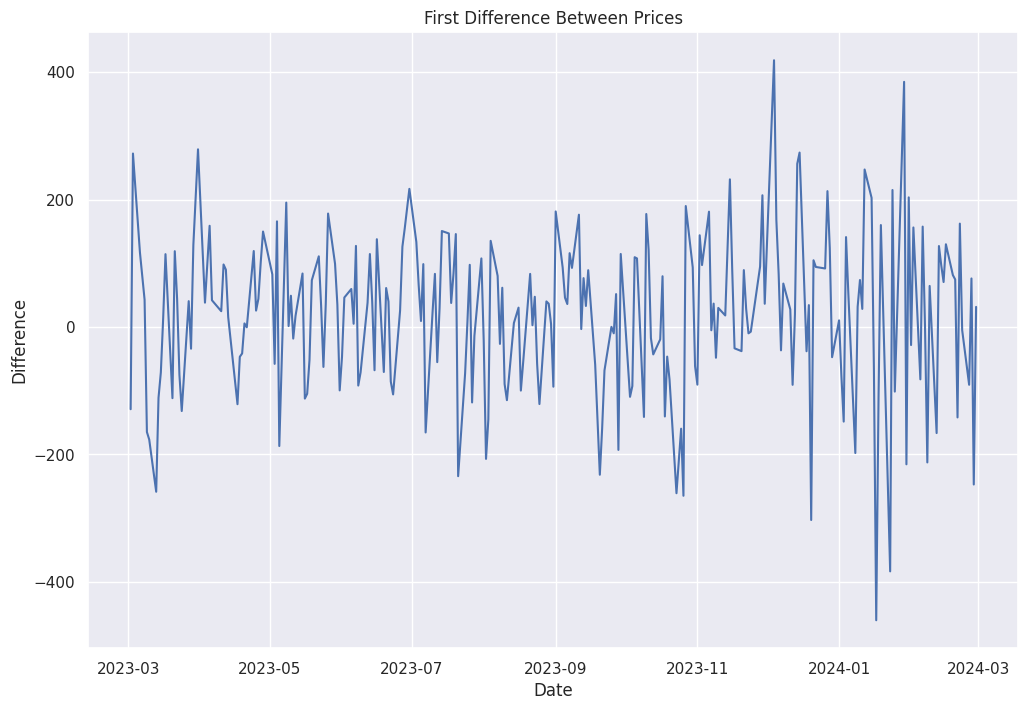

In [ ]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.lineplot(data = first_diff_df)

# Add title and labels
plt.title('First Difference Between Prices')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.show()

#AutoCorrelation (ACF) and Partial AutoCorrelation (PACF)

These tests are basicaly used to find relation between the current observation with its previous lags, Hgher the dependence higher will be the value.

<ul>
<li> ACF - Direct and Indirect Realtions both</li>
<li> PACF - Only Direct Relations </li>
</ul>


Thse tests are helpful for deciding parameters while applying ARIMA and SARIMA models as we need to sepcify the order.

Example - No. of lags having signfiacant value (other than statical 0) -> Order of AR model...



Start With ACF

Note - We will use stationary data to plot ACF and PACF to get better results.

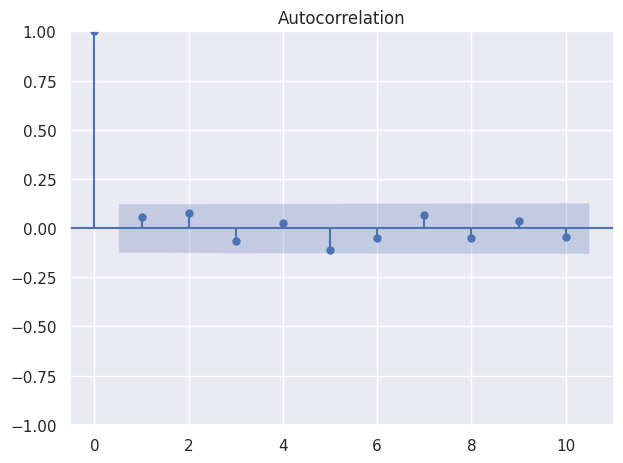

In [ ]:
plot_acf(first_diff_df, lags = 10)
plt.tight_layout()
plt.show()

We can see that as we move farther from present closing price correlation decresases..

Now PACF -

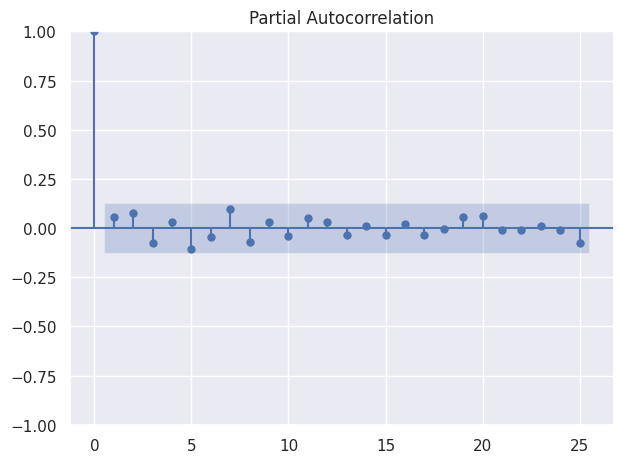

In [ ]:
plot_pacf(first_diff_df, lags = 25)
plt.tight_layout()
plt.show()

Hence both PACF and ACF help us to find the value of order for a particular TS model which helps in increasing the accuracy of the model

# Building a Time Series Model

#Data Prep Prep Prep!!!

<ul>
<li>Ensure the data is preprocessed appropriately (e.g., handling missing values)</li>
<li>Split the data into training, validation, and test sets.</li>
</ul>


In [ ]:
# Delete the rows with mssing values..
df.dropna(inplace=True)

As the market is closed on weekends including some other holidays also, we will have to fill missing values for those days to make the data smooth.

- Comment out the lower cell if you want to avoid this step..

In [ ]:
# # Perform linear interpolation to fill missing values for those days on which market was closed...
# complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
# df = df.reindex(complete_date_range)
# df = df.interpolate(method='linear')
# df.head()

In [ ]:
# # Do same with first_diff_df
# complete_date_range = pd.date_range(start=first_diff_df.index.min(), end=first_diff_df.index.max(), freq='D')
# first_diff_df = first_diff_df.reindex(complete_date_range)
# first_diff_df = first_diff_df.interpolate(method='linear')
# first_diff_df.head()

<h1> Data Spliting!!! </h1>

In [ ]:
# For now, only dividing into training and test set..

# We will train the model for 12 months and will test its performance over a month...
training_start_date = '2023-03-01'
training_end_date = '2024-02-29'

training_df = df.loc[training_start_date : training_end_date]

In [ ]:
training_df.head()

Date
2023-03-01    17450.900391
2023-03-02    17321.900391
2023-03-03    17594.349609
2023-03-06    17711.449219
2023-03-08    17754.400391
Name: Close, dtype: float64

<h1> Now Load the Test Set </h1>

In [ ]:
test_data = yf.download("^NSEI",  start = "2024-04-01", end = "2024-05-01")
test_df = test_data['Close']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Do linear interpolation with test data too..
complete_date_range = pd.date_range(start=test_df.index.min(), end=test_df.index.max(), freq='D')
test_df = test_df.reindex(complete_date_range)
test_df = test_df.interpolate(method='linear')
test_df.head()

2024-04-01    22462.000000
2024-04-02    22453.300781
2024-04-03    22434.650391
2024-04-04    22514.650391
2024-04-05    22513.699219
Freq: D, Name: Close, dtype: float64

In [ ]:
# Infer the frequency to train the model properly..
training_df = training_df.asfreq('D')

#Model Implementation


---
<br>

  # 1. ARIMA (p,d,q)



1.   AR - Auto Regressive Model - In this model, the current lag depends linearly on its perivious lags, which means the Time Series is Auto Regressive as it is moving forward using its own old values.

  Order - p, decided by looking at PACF.



2.   MA - Moving Average Model - In this model, the current lag is sum of a constant term along with a linear combination of errors that is the difference between predicted values of previous lags and observed values.

  Order - q, decided by looking at ACF.



3. I - Integrated Model - This is used for non-stationary data when we need to take differences to get a stationary data.

  Order - d, can be decided by running adf tests.

Implementation :



In [ ]:
model = ARIMA(training_df, order=(5, 2, 5))
model_fit = model.fit()

In [ ]:
model_fit.summary()             # This prints the overview of training process and tell us the importance of lags in both models.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  366
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -1538.374
Date:                Tue, 25 Jun 2024   AIC                           3098.749
Time:                        21:49:20   BIC                           3141.617
Sample:                    03-01-2023   HQIC                          3115.787
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3212      0.140     -9.458      0.000      -1.595      -1.047
ar.L2         -1.2964      0.158     -8.230      0.000      -1.605      -0.988
ar.L3         -1.3209      0.152     -8.713      0.000      -1.618      -1.024
ar.L4         -1.0095      0.169     -5.974      0.000      -1.341      -0.678
ar.L5         -0.0086      0.104     -0.083      0.934      -0.212       0.195
ma.L1          0.3007      0.851      0.353      0.724      -1.367       1.968
ma.L2         -0.0334      1.802     -0.019      0.985      -3.565       3.498
ma.L3          0.0331      1.779      0.019      0.985      -3.454       3.520
ma.L4         -0.3025      0.834     -0.363      0.717      -1.936       1.331
ma.L5         -0.9980      0.178     -5.604      0.000      -1.347      -0.649
sigma2      1.875e+04      0.000   5.74e+07      0.000    1.87e+04    1.87e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):               119.93
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.64e+23. Standard errors may be unstable.
"""

<h1> Predicition Time!!! </h1>

In [ ]:
test_start_time = test_df.index[0]
test_end_time = test_df.index[-1]

predict = model_fit.predict(start=test_start_time, end=test_end_time)
predict.head()

2024-04-01    22392.221111
2024-04-02    22426.818934
2024-04-03    22437.802201
2024-04-04    22417.050183
2024-04-05    22437.449485
Freq: D, Name: predicted_mean, dtype: float64

Now after predicition, it is time to prepare results with graphs and evaluation metrices, which the following function will do!!

In [ ]:
def prepare_result(y_pred, y_true, training_data):
  # Function to summarise the model evaluation results, by plotting graphs and displaying evaluation metrics..

  # Plot both in same graph to compare between them (line plots for actual vs predicted values)..

  # plt.plot(pd.concat([y_true,training_data]), label='Actual')
  plt.plot(y_true, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.legend()
  plt.show()

  print("\n")

  # Plot the residuals graph i.e. y_true - y_predict
  residuals = y_true - y_pred
  sns.lineplot(data = residuals, label = "Residual")
  plt.axhline(y=0, color='r', linestyle='--')
  plt.xlabel('Date')
  plt.ylabel('Residuals')
  plt.show()

  # Calculate and print relevant metrics (e.g., RMSE, MAE) to evaluate the models' performance..
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)

  rmse_f = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
  mae_f = np.mean(np.abs(y_true - y_pred))/np.mean(y_true)

  print("\n")
  print("Model Evaluation Summary: ")
  print(f"RMSE: {rmse}")
  print(f"RMSE (fractional): {rmse_f}")
  print(f"MAE: {mae}")
  print(f"MAE (fractional): {mae_f}")


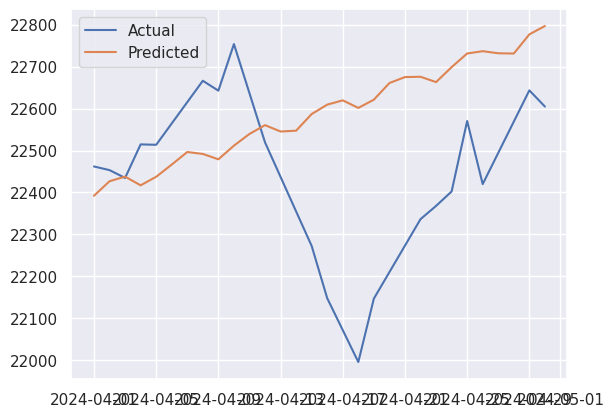

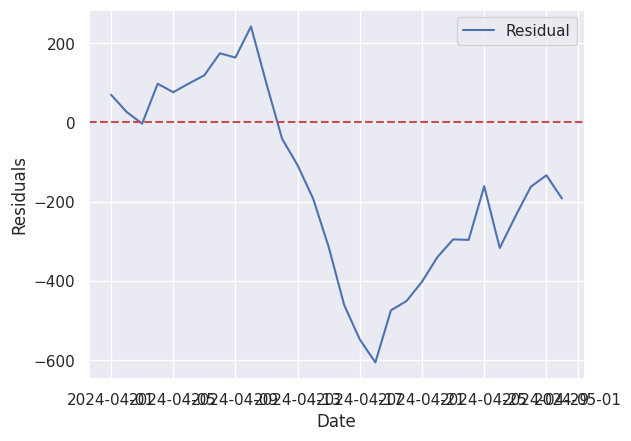



Model Evaluation Summary: 
RMSE: 279.4613160134213
RMSE (fractional): 0.01256543165851453
MAE: 230.00469094379915
MAE (fractional): 0.010251342862172745


In [ ]:
prepare_result(predict, test_df, training_df)